<h1><strong>Sistem Rekomendasi: Rekomendasi Kursus Online untuk Pengguna di Udemy</strong></h1>

# Pendahuluan

Proyek ini bertujuan untuk membuat sistem rekomendasi kursus online untuk pengguna di Udemy menggunakan _content-based filtering_. Untuk memudahkan navigasi gunakan menu `Table of Contents` di kanan atas Google Colaboratory.

# 1. Impor modul python yang dibutuhkan

In [1]:
# Memasang modul plotly, scikit-learn, & neattext terbaru
!pip install -q -U plotly
!pip install -q -U scikit-learn
!pip install -q -U neattext

     |████████████████████████████████| 23.9 MB 1.6 MB/s 
     |████████████████████████████████| 23.2 MB 112.0 MB/s 
     |████████████████████████████████| 114 kB 5.1 MB/s 


In [2]:
# Untuk pengolahan data
import numpy as np
import pandas as pd
import neattext.functions as nfx

# Untuk visualisasi data
import missingno as msno
import plotly.express as px
from plotly.offline import iplot

# Untuk pembuatan sistem rekomendasi 
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# 2. Persiapan Dataset

## 2.1 Kredensial akun Kaggle

In [3]:
# Membuat folder .kaggle di dalam folder root, kemudian menyalin berkas kaggle.json pada direktori aktif saat ini ke folder .kaggle
!chmod 600 kaggle.json && (ls ~/.kaggle 2>/dev/null || mkdir ~/.kaggle) && mv kaggle.json ~/.kaggle/

## 2.2 Unduh dan menyiapkan Dataset

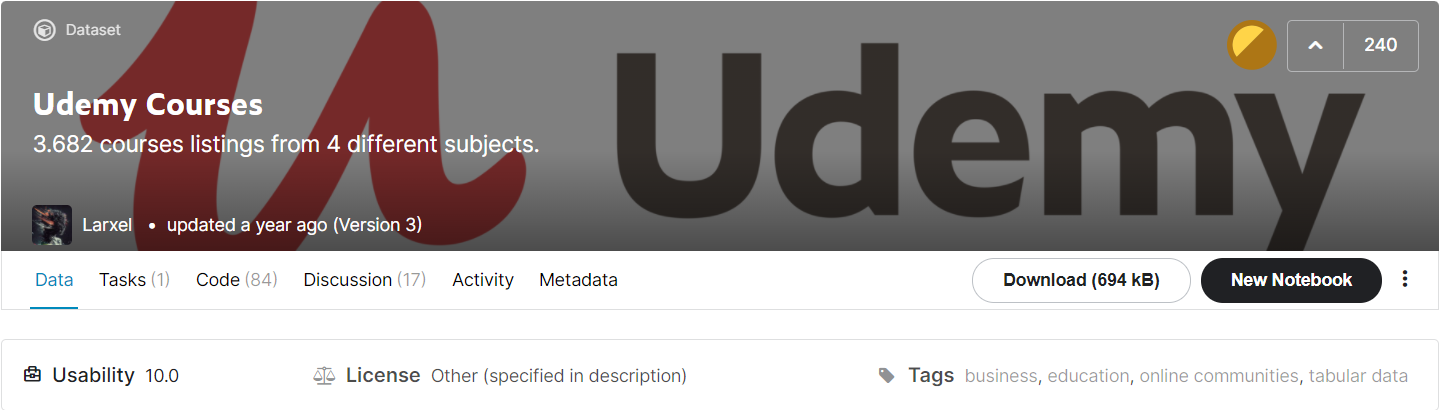

Informasi Dataset:

| Jenis | Keterangan |
|:-----:|:-----------|
| Sumber | [Kaggle Dataset: Udemy Courses](https://www.kaggle.com/andrewmvd/udemy-courses) |
| Lisensi | License was not specified at source |
| Kategori | Bisnis, Edukasi, Komunitas Online |
| Rating Penggunaan | 10.0 (Gold) |
| Jenis dan Ukuran Berkas | zip (694 kB) |

In [4]:
# Mengunduh dataset menggunakan Kaggle CLI
!kaggle datasets download -d andrewmvd/udemy-courses

  0% 0.00/200k [00:00<?, ?B/s]
100% 200k/200k [00:00<00:00, 29.9MB/s]


In [5]:
# Mengekstrak berkas zip ke direktori aktif saat ini dan menghapus file zip
!unzip -q /content/udemy-courses.zip && rm udemy-courses.zip

# 3. Pemahaman Data _(Data Understanding)_

## 3.1 Memuat Data pada sebuah Dataframe menggunakan pandas

In [6]:
# Memuat data pada dataframe 
raw_df = pd.read_csv('/content/udemy_courses.csv')

In [7]:
# Pratinjau dataset
raw_df.head()

,course_id,course_title,url,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,published_timestamp,subject
0,1070968,Ultimate Investment Banking Course,https://www.udemy.com/ultimate-investment-bank...,True,200,2147,23,51,All Levels,1.5,2017-01-18T20:58:58Z,Business Finance
1,1113822,Complete GST Course & Certification - Grow You...,https://www.udemy.com/goods-and-services-tax/,True,75,2792,923,274,All Levels,39.0,2017-03-09T16:34:20Z,Business Finance
2,1006314,Financial Modeling for Business Analysts and C...,https://www.udemy.com/financial-modeling-for-b...,True,45,2174,74,51,Intermediate Level,2.5,2016-12-19T19:26:30Z,Business Finance
3,1210588,Beginner to Pro - Financial Analysis in Excel ...,https://www.udemy.com/complete-excel-finance-c...,True,95,2451,11,36,All Levels,3.0,2017-05-30T20:07:24Z,Business Finance
4,1011058,How To Maximize Your Profits Trading Options,https://www.udemy.com/how-to-maximize-your-pro...,True,200,1276,45,26,Intermediate Level,2.0,2016-12-13T14:57:18Z,Business Finance


## 3.2 Deskripsi variabel pada dataset

In [8]:
# Memuat informasi dataframe
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3678 entries, 0 to 3677
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   course_id            3678 non-null   int64  
 1   course_title         3678 non-null   object 
 2   url                  3678 non-null   object 
 3   is_paid              3678 non-null   bool   
 4   price                3678 non-null   int64  
 5   num_subscribers      3678 non-null   int64  
 6   num_reviews          3678 non-null   int64  
 7   num_lectures         3678 non-null   int64  
 8   level                3678 non-null   object 
 9   content_duration     3678 non-null   float64
 10  published_timestamp  3678 non-null   object 
 11  subject              3678 non-null   object 
dtypes: bool(1), float64(1), int64(5), object(5)
memory usage: 319.8+ KB


In [9]:
# Menghitung jumlah data kosong pada setiap kolom
raw_df.isna().sum()

course_id              0
course_title           0
url                    0
is_paid                0
price                  0
num_subscribers        0
num_reviews            0
num_lectures           0
level                  0
content_duration       0
published_timestamp    0
subject                0
dtype: int64

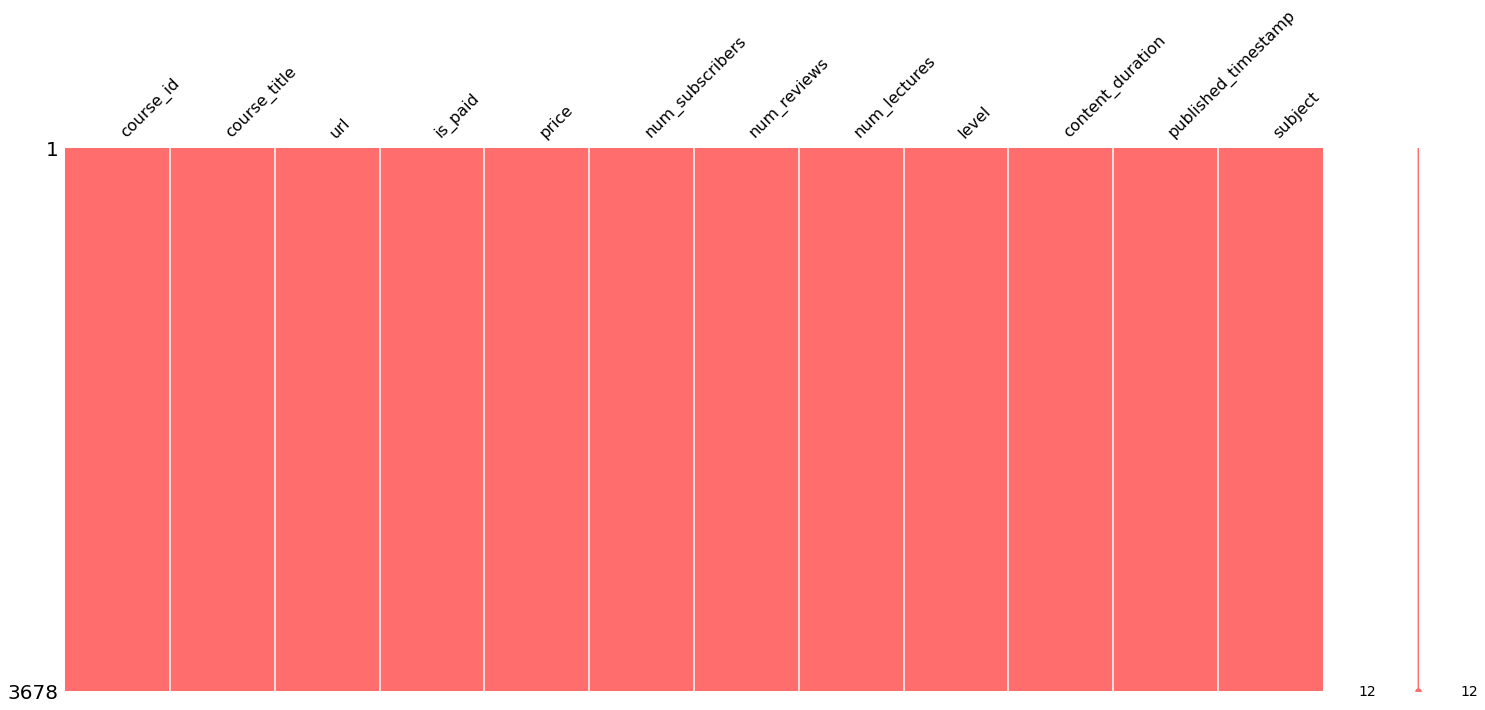

In [10]:
# Memvisualisasikan data kosong pada setiap kolom
sorted_null = msno.nullity_sort(raw_df, sort='ascending') 
figures = msno.matrix(sorted_null, color=(1, 0.43, 0.43))

# 4. Persiapan Data _(Data Preparation)_ dan Visualisasi Data

## 4.1 Pembersihan data duplikasi

In [11]:
# Melihat jumlah data duplikasi
raw_df.duplicated().sum()

6

In [12]:
# Menghapus data duplikasi
raw_df.drop_duplicates(inplace=True)

In [13]:
# Melihat informasi dataframe
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3672 entries, 0 to 3677
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   course_id            3672 non-null   int64  
 1   course_title         3672 non-null   object 
 2   url                  3672 non-null   object 
 3   is_paid              3672 non-null   bool   
 4   price                3672 non-null   int64  
 5   num_subscribers      3672 non-null   int64  
 6   num_reviews          3672 non-null   int64  
 7   num_lectures         3672 non-null   int64  
 8   level                3672 non-null   object 
 9   content_duration     3672 non-null   float64
 10  published_timestamp  3672 non-null   object 
 11  subject              3672 non-null   object 
dtypes: bool(1), float64(1), int64(5), object(5)
memory usage: 347.8+ KB


In [14]:
# Hasil data setelah dibersihkan
raw_df.head(5)

,course_id,course_title,url,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,published_timestamp,subject
0,1070968,Ultimate Investment Banking Course,https://www.udemy.com/ultimate-investment-bank...,True,200,2147,23,51,All Levels,1.5,2017-01-18T20:58:58Z,Business Finance
1,1113822,Complete GST Course & Certification - Grow You...,https://www.udemy.com/goods-and-services-tax/,True,75,2792,923,274,All Levels,39.0,2017-03-09T16:34:20Z,Business Finance
2,1006314,Financial Modeling for Business Analysts and C...,https://www.udemy.com/financial-modeling-for-b...,True,45,2174,74,51,Intermediate Level,2.5,2016-12-19T19:26:30Z,Business Finance
3,1210588,Beginner to Pro - Financial Analysis in Excel ...,https://www.udemy.com/complete-excel-finance-c...,True,95,2451,11,36,All Levels,3.0,2017-05-30T20:07:24Z,Business Finance
4,1011058,How To Maximize Your Profits Trading Options,https://www.udemy.com/how-to-maximize-your-pro...,True,200,1276,45,26,Intermediate Level,2.0,2016-12-13T14:57:18Z,Business Finance


## 4.2 Visualisasi data

In [15]:
# Fungsi untuk plot distribusi data pada suatu kolom numerik
def plot_distribution(column:str, title:str):
  figures = px.histogram(data_frame=raw_df,
                        x=column,
                        color='is_paid',
                        template='plotly_white',
                        marginal='box',
                        color_discrete_sequence=["#FF7171","#9FD8DF"],
                        barmode='overlay',
                        histfunc='count')

  figures.update_layout(font_family='Open Sans',
                        title=dict(text=title,
                                  x=0.5,
                                  font=dict(color="#333",size=20)),
                        hoverlabel=dict(bgcolor='white'))

  figures.update_xaxes(
      automargin=True
  )

  iplot(figures)

# Fungsi untuk plot bar data pada suatu kolom numerik
def plot_bar(column:str, title:str):
  figures = px.bar(data_frame=raw_df,
                  x="subject",
                  y=column, 
                  color="is_paid", 
                  barmode="group",
                  template='plotly_white',
                  color_discrete_sequence=["#FF7171","#9FD8DF"])

  figures.update_layout(font_family='Open Sans',
                        title=dict(text=title,
                                  x=0.5,
                                  font=dict(color="#333",size=20)),
                        hoverlabel=dict(bgcolor='white'))

  figures.update_xaxes(
      automargin=True
  )

  iplot(figures)

# Fungsi untuk plot pie data pada suatu kolom kategori
def plot_category(column:str, title:str):
  figures = px.sunburst(raw_df,
                      path=["is_paid",column],
                      color="num_subscribers", 
                      color_continuous_scale=["#9FD8DF","#FF7171"])

  figures.update_layout(font_family='Open Sans',
                        title=dict(text=title,
                                   x=0.5,
                                   font=dict(color="#333",size=20)),
                        title_y=0.96)

  figures.update_traces(hovertemplate="Labels = %{label}<br>Count = %{value}<br>Subscribers = %{color:.0f} <extra></extra>")

  figures.update_xaxes(
      automargin=True
  )

  iplot(figures)

### 4.2.1 Fitur numerik

In [16]:
# Menampilkan visualisasi data
for column in ['price', 'num_subscribers', 'num_reviews', 'num_lectures', 'content_duration']:
  plot_distribution(column=column, title=f"Distribusi fitur numerik pada kolom {column}")

In [17]:
# Menampilkan visualisasi data
for column in ['price', 'num_subscribers', 'num_reviews', 'num_lectures', 'content_duration']:
  plot_bar(column=column, title=f"Distribusi label {column} dengan label subjek<br>Berdasarkan tipe kursus")

### 4.2.2 Fitur kategori

In [18]:
# Menampilkan visualisasi data
for column in [ 'level', 'subject']:
  plot_category(column=column, title=f"Distribusi label {column} dan tipe kursus<br>Berdasarkan jumlah subscriber")

## 4.3 Seleksi dan Pembersihan data yang digunakan sebagai fitur

In [19]:
# Memberi nama ulang kolom course_title yang berlum diproses
raw_df['raw_course_title'] = raw_df['course_title']

### 4.3.1 Membersihkan `stopwords`

In [20]:
# Menghilangkan stopword pada course_title
raw_df['course_title'] = raw_df['raw_course_title'].apply(nfx.remove_stopwords)

### 4.3.2 Membersihkan karakter spesial

In [21]:
# Menghapus karakter spesial pada course_title
raw_df['course_title'] = raw_df['course_title'].apply(nfx.remove_special_characters)

In [22]:
# Melihat perbandingan course_title yang telah dibersihkan
raw_df[['course_title', 'raw_course_title']]

,course_title,raw_course_title
0,Ultimate Investment Banking Course,Ultimate Investment Banking Course
1,Complete GST Course Certification Grow Practice,Complete GST Course & Certification - Grow You...
2,Financial Modeling Business Analysts Consultants,Financial Modeling for Business Analysts and C...
3,Beginner Pro Financial Analysis Excel 2017,Beginner to Pro - Financial Analysis in Excel ...
4,Maximize Profits Trading Options,How To Maximize Your Profits Trading Options
...,...,...
3673,Learn jQuery Scratch Master JavaScript library,Learn jQuery from Scratch - Master of JavaScri...
3674,Design WordPress Website Coding,How To Design A WordPress Website With No Codi...
3675,Learn Build Polymer,Learn and Build using Polymer
3676,CSS Animations Create Amazing Effects Website,CSS Animations: Create Amazing Effects on Your...


## 4.4 Rekayasa Fitur dengan TF-IDF Vectorizer

In [23]:
# Menyimpan indeks kursus
course_indices = pd.Series(raw_df.index,index=raw_df['course_title']).drop_duplicates()
course_indices.head()

course_title
Ultimate Investment Banking Course                   0
Complete GST Course  Certification  Grow Practice    1
Financial Modeling Business Analysts Consultants     2
Beginner Pro  Financial Analysis Excel 2017          3
Maximize Profits Trading Options                     4
dtype: int64

In [24]:
# Menyimpan nama-nama kursus pada dataframe baru
df_course = pd.DataFrame({'course_title':raw_df['course_title']})

# Pratinjau data
df_course.head()

,course_title
0,Ultimate Investment Banking Course
1,Complete GST Course Certification Grow Practice
2,Financial Modeling Business Analysts Consultants
3,Beginner Pro Financial Analysis Excel 2017
4,Maximize Profits Trading Options


In [25]:
# Inisialisasi TfidfVectorizer
vect = TfidfVectorizer()

# Vektorisasi teks
tfidf_matrix = vect.fit_transform(raw_df['course_title'])

In [26]:
# Ubah vektor ke dataframe
df = pd.DataFrame(tfidf_matrix.todense(), columns=vect.get_feature_names_out())

# Pratinjau data
df.head()

,000005,001,01,02,10,100,101,101master,102,10k,10th,11,110,111creating,112,12,123d,13,13customer,14,15,150,16,16propertyplant,17,175,175pa,18,183pa,1872,188,19,1a,1presentation,1year,20,200,201,2012,2013,...,wp,wpfaster,write,writing,written,wz,wzorkw,x7,x8,xampp,xd,xero,xito,xml,xpath,xquery,xsd,xslt,xstream,xv,xxi,yang,yearend,years,yen,yesterday,yield,you,youtube,zeichnen,zend,zero,zerotohero,zf2,zinsen,zoho,zombie,zu,zuhause,zur
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 5. Pembuatan Sistem Rekomendasi _Content-Based Filtering_

## 5.1 Dengan model K-Nearest Neighbor

In [27]:
# Membuat sistem rekomendasi dengan model K-Nearest Neighbor
# Inisiasi model 
model = NearestNeighbors(metric='euclidean')

# Melakukan fitting model terhadap data
model.fit(df)

NearestNeighbors(metric='euclidean')

In [28]:
# Membuat fungsi untuk mendapatkan rekomendasi
# Dengan model KNN
def getRecommendedCourses_model(course_title:str, recommend_courses:int=10):
  idx = course_indices[course_title]
  print(f'Apabila pengguna menyukai course {course_title[0]}\n{recommend_courses} course berikut ini juga mungkin akan disukai :')
  # Mencari course terdekat dengan course yang diikuti pengguna
  distances, neighbors = model.kneighbors(df.loc[idx],n_neighbors=recommend_courses)
  # Memasukkan course yang sama pada sebuah list
  similar_courses = []
  for course in df_course.loc[neighbors[0][:]].values:
    similar_courses.append(course[0])
  # Memasukan skornya (jarak) pada sebuah list
  similar_distance = []
  for distance in distances[0]:
    similar_distance.append(f"{round(100-distance, 2)}%")
  # Mengembalikan sebuah dataframe berupa rekomendasi berdasarkan judul course
  return pd.DataFrame(data = {"Judul Kursus" : similar_courses, "Tingkat Kesamaan" : similar_distance})

In [29]:
# Memberikan rekomendasi terhadap course yang
# Serupa dengan Succeed Forex Know Start
getRecommendedCourses_model(df_course.loc[500])

Apabila pengguna menyukai course Succeed Forex Know Start
10 course berikut ini juga mungkin akan disukai :


,Judul Kursus,Tingkat Kesamaan
0,Succeed Forex Know Start,100.0%
1,Double Entry Bookkeeping,99.46%
2,Public Speaking Great Financial Presentations,99.44%
3,Financial Analysis Scratch Professional,99.38%
4,Succeed Bonds Know Start,99.32%
5,Succeed Lotto Know Start,99.27%
6,Comment jouer du Pianoforte,99.0%
7,15 Mandamientos para ganar dinero en Bolsa,99.0%
8,Contabilit Generale,99.0%
9,Cost Capital Weighted Average Cost Capital,99.0%


## 5.2 Dengan Cosine Similarity

In [30]:
# Menghitung cosine similarity dari dataframe
cosine_sim = cosine_similarity(df)

# Menyimpan hasil perhitungan pada dataframe
cosine_sim_df = pd.DataFrame(cosine_sim, index=df_course['course_title'], columns=df_course['course_title'])
cosine_sim_df.head(3)

course_title,Ultimate Investment Banking Course,Complete GST Course Certification Grow Practice,Financial Modeling Business Analysts Consultants,Beginner Pro Financial Analysis Excel 2017,Maximize Profits Trading Options,Trading Penny Stocks Guide Levels 2017,Investing Trading Beginners Mastering Price Charts,Trading Stock Chart Patterns Immediate Explosive Gains,Options Trading 3 Advanced Stock Profit Success Method,Investment Strategy Need Retirement,Forex Trading Secrets Pros Amazons AWS,Trading Options Money Flow,Financial Management Risk Return Securities,Forex Trading Course Work Smarter Harder Proven Results,Python Algo Trading Sentiment Trading News,Short Selling Learn Sell Stocks Fall,Basic Technical Analysis Learn structure market,Complete Chart Pattern Trading Course Proven Approach,7 Deadly Mistakes Investing Slash Profits,Financial Statements Easy,Winning Forex Trading Live Forex Trading Examples,Forex Traders Create Trading Robot Coding,Create Business Home Trading Stocks Today 2017,Introduction Accounting Mastering Financial Statements,Complete Ethereum Course 01 Ether Wallet,Beginner Pro PowerPoint Complete PowerPoint Training,Investing 101 Complete Online Investing Course,Create Hedge Fund Trade Stocks Like Fund Manager,Learn MQL5 Build 8Currency Hedging Robot MetaTrader 5,Forex Trading Complete Guide Started Like Pro,Python Algo Stock Trading Automate Trading,Forex Robot Incredible ROI Robot Included,Complete Bitcoin Course 001 Bitcoin Wallet,Mastering High Probability Iron Condor Options Trading,Complete Short Course Ethereum,Options Trading Stocks Proven Toolbox Financial Success,Forex Trading AZ LIVE Examples Forex Trading,Introduction Finance Accounting Modeling Valuation,Beginner Pro Excel Financial Modeling Valuation,Complete Investment Banking Course 2017,...,Building Search Engine PHP MySQL,create search engine website,Learn basics HTML 30 Minutes,JavaScript Scratch Beginners,Learn Web Development Creating Social Network,CSS Image filters modern web images color manipulation,Building Responsive Websites Bootstrap 3 Framework,Create Membership Site Wishlist Member Wordpress,Convert HTML Websites PHP Learn 40 Minutes,17 Complete JavaScript projects explained step step,Mastering Unix AWK Commands,CakephpCreating CRUD application,HTML CSS Guide Web Design,Drupal 8 Site Building,Learn Bootstrap 4 Popular HTML5 CSS3 JS Framework,Essentials Spring 50 Developers,Extreme Web Development Course Beginners,JQuery DOM Ajax Concept Explained Beginners,HTML Forms Beginners Basic Introduction,Ultimate JavaScript Objects,Complete Web Developer Course Build 20 Websites,Simple Javascript Learn Doing Beginners Welcome,Learn HTML CSS Ruby Rails Build Blog,Learn HTML5 Canvas beginners,Bootstrap 4 Beginners Code Responsive Landing Page,Build Wordpress CMS Clone Laravel 5,XML DTD Crash Course Beginners,Beginner Photoshop HTML5 CSS3,XPATH basics beginners,Fastest Way Create Website Godaddy,guide HTML,Building Better APIs GraphQL,Learn Grunt Examples Automate End Workflow,Build Stock Downloader Visual Studio 2015 C,jQuery UI Action Build 5 jQuery UI Projects,Learn jQuery Scratch Master JavaScript library,Design WordPress Website Coding,Learn Build Polymer,CSS Animations Create Amazing Effects Website,MODX CMS Build Websites Beginners Guide
course_title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ultimate Investment Banking Course,1.000000,0.078268,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.251893,0.0,0.0,0.000000,0.065527,0.0,0.0,0.0,0.079544,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.072963,0.000000,0.086151,0.0,0.0,0.000000,0.0,0.0,0.070185,0.0,0.105367,0.000000,0.0,0.000000,0.000000,0.714217,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.107141,0.0,0.0,0.262381,0.097870,0.0,0.0,0.0,0.0,0.0,0.094257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Complete GST Course Certification Grow Practice,0.078268,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000

In [31]:
# Membuat fungsi untuk mendapatkan rekomendasi
# Dengan Cosine Similarity
def getRecommendedCourses_cosine(course_title:str, recommended_courses:int=10):
  print(f'Apabila pengguna menyukai course {course_title[0]}\n{recommended_courses} course berikut ini juga mungkin akan disukai :')
  # Mencari nilai unik pada course yang dimainkan pengguna di baris dataframe cosine sim
  # Nilai unik (arr) dikembalikan dalam bentuk yang berurutan dari kecil ke besar 
  arr, ind = np.unique(cosine_sim_df.loc[course_title[0]], return_index=True)
  # Memasukkan nama course yang serupa dari index kedua terakhir sampai index n terakhir
  similar_course = []
  for index in ind[-(recommended_courses+1):-1]:
    similar_course.append(df_course.loc[index][0])
  # Memasukkan skor cosine dari course yang serupa mulai dari index kedua terakhir sampai index n terakhir
  cosine_score = []
  for score in arr[-(recommended_courses+1):-1]:
    cosine_score.append(score)
  # Mengembalikan sebuah dataframe berupa rekomendasi berdasarkan judul course
  return pd.DataFrame(data = {"Judul Kursus" : similar_course, "Cosine Similarity" : cosine_score}).sort_values(by='Cosine Similarity',ascending=False).reset_index(drop=True)

In [32]:
# Memberikan rekomendasi terhadap course yang
# Serupa dengan Succeed Forex Know Start
getRecommendedCourses_cosine(df_course.loc[500])

Apabila pengguna menyukai course Succeed Forex Know Start
10 course berikut ini juga mungkin akan disukai :


,Judul Kursus,Cosine Similarity
0,Double Entry Bookkeeping,0.854579
1,Public Speaking Great Financial Presentations,0.841856
2,Financial Analysis Scratch Professional,0.806692
3,Succeed Bonds Know Start,0.768706
4,Succeed Lotto Know Start,0.732243
5,Blues Master Advanced Techniques Piano Course,0.460829
6,Simple things know start FOREX OFFER,0.454957
7,Know Trader,0.364812
8,Piano Skills TODAY,0.284592
9,Learn jQuery Example Course,0.275319


# 6. Evaluasi

In [33]:
# Fungsi untuk menghitung nilai presisi dari sistem rekomendasi
def precision(query:pd.DataFrame, rec_result:pd.DataFrame):
  relevant = 0
  for result in rec_result['subject'].values.tolist():
    if query['subject'].values == result:
      relevant += 1
  return relevant/len(rec_result)

In [34]:
# Query input untuk evaluasi
query_input = raw_df.loc[raw_df['course_title'].isin(df_course.loc[500].values.tolist())][['course_title', 'subject']]
query_input

,course_title,subject
500,Succeed Forex Know Start,Business Finance


## 6.1 Skor Precision Model K-Nearest Neighbor

In [35]:
# Memberikan rekomendasi terhadap course yang
# Serupa dengan Succeed Forex Know Start
# Dengan model KNN
knn_result_df = getRecommendedCourses_model(df_course.loc[500])
knn_result_df

Apabila pengguna menyukai course Succeed Forex Know Start
10 course berikut ini juga mungkin akan disukai :


,Judul Kursus,Tingkat Kesamaan
0,Succeed Forex Know Start,100.0%
1,Double Entry Bookkeeping,99.46%
2,Public Speaking Great Financial Presentations,99.44%
3,Financial Analysis Scratch Professional,99.38%
4,Succeed Bonds Know Start,99.32%
5,Succeed Lotto Know Start,99.27%
6,Comment jouer du Pianoforte,99.0%
7,15 Mandamientos para ganar dinero en Bolsa,99.0%
8,Contabilit Generale,99.0%
9,Cost Capital Weighted Average Cost Capital,99.0%


In [36]:
# Menyimpan course_title dan subject untuk proses evaluasi
knn_result = raw_df.loc[raw_df['course_title'].isin(knn_result_df['Judul Kursus'].values.tolist())][['course_title', 'subject']]
knn_result

,course_title,subject
214,Succeed Bonds Know Start,Business Finance
216,Succeed Lotto Know Start,Business Finance
500,Succeed Forex Know Start,Business Finance
811,Double Entry Bookkeeping,Business Finance
949,Public Speaking Great Financial Presentations,Business Finance
1043,15 Mandamientos para ganar dinero en Bolsa,Business Finance
1045,Contabilit Generale,Business Finance
1106,Cost Capital Weighted Average Cost Capital,Business Finance
1113,Financial Analysis Scratch Professional,Business Finance
2204,Comment jouer du Pianoforte,Musical Instruments


In [37]:
# Perhitungan precision model KNN
print(f"Skor precision menggunakan K-Nearest Neighbor adalah {precision(query_input, knn_result)*100}%")

Skor precision menggunakan K-Nearest Neighbor adalah 90.0%


## 6.2 Skor Precision dengan Cosine Similarity

In [38]:
# Memberikan rekomendasi terhadap course yang
# Serupa dengan Succeed Forex Know Start
# Dengan Cosine Similarity
cosine_result_df = getRecommendedCourses_cosine(df_course.loc[500])
cosine_result_df

Apabila pengguna menyukai course Succeed Forex Know Start
10 course berikut ini juga mungkin akan disukai :


,Judul Kursus,Cosine Similarity
0,Double Entry Bookkeeping,0.854579
1,Public Speaking Great Financial Presentations,0.841856
2,Financial Analysis Scratch Professional,0.806692
3,Succeed Bonds Know Start,0.768706
4,Succeed Lotto Know Start,0.732243
5,Blues Master Advanced Techniques Piano Course,0.460829
6,Simple things know start FOREX OFFER,0.454957
7,Know Trader,0.364812
8,Piano Skills TODAY,0.284592
9,Learn jQuery Example Course,0.275319


In [39]:
# Menyimpan course_title dan subject untuk proses evaluasi
cosine_result = raw_df.loc[raw_df['course_title'].isin(cosine_result_df['Judul Kursus'].values.tolist())][['course_title', 'subject']]
cosine_result

,course_title,subject
214,Succeed Bonds Know Start,Business Finance
216,Succeed Lotto Know Start,Business Finance
394,Simple things know start FOREX OFFER,Business Finance
485,Know Trader,Business Finance
811,Double Entry Bookkeeping,Business Finance
949,Public Speaking Great Financial Presentations,Business Finance
1113,Financial Analysis Scratch Professional,Business Finance
2090,Blues Master Advanced Techniques Piano Course,Musical Instruments
2163,Piano Skills TODAY,Musical Instruments
3074,Learn jQuery Example Course,Web Development


In [40]:
# Perhitungan precision
print(f"Skor precision menggunakan Cosine Similarity adalah {precision(query_input, cosine_result)*100}%")

Skor precision menggunakan Cosine Similarity adalah 70.0%


# Penutupan

Model untuk memberikan rekomendasi kursus online untuk pengguna di Udemy telah selesai dibuat. Setelah diujikan, model ini bekerja cukup baik dalam memberikan 5 rekomendasi teratas terhadap kursus yang diikuti pengguna. Namun, masih ada beberapa kekurangan dari model yang dibuat seperti yang terlihat pada skor Precision. Untuk memperbaikinya dapat digunakan algoritma untuk membuat model rekomendasi yang lain seperti menggunakan _deep learning_ lalu dibandingkan performanya dengan model KNN saat ini.


### Referensi
* Dokumentasi Scikit-learn: https://scikit-learn.org/stable/
* Dokumentasi Plotly: https://plotly.com/python/
* Dokumentasi Neat Text: https://blog.jcharistech.com/neattext/
* Lainnya:
  * https://www.kaggle.com/andrewmvd/udemy-courses
  * https://www.kaggle.com/kaanboke/plotly-beginner-friendly-udemy
  * https://www.kaggle.com/shirishsharma/analysis-of-data-with-plotly-and-ml-models


